Dataset Generation
Jinwei Yao

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # define GPU id, remove if you want to use all GPUs available
import torch
gpu=torch.cuda.get_device_name(0)
print(gpu)
from contextlib import contextmanager
import numpy as np
import transformers

print("Transformers version:", transformers.__version__)

from medusa.model.medusa_model import MedusaModel
from medusa.model.kv_cache import *
from medusa.model.utils import *
from medusa.model.medusa_choices import *
from copy import deepcopy
import matplotlib.pyplot as plt

NVIDIA A100-SXM4-80GB
Transformers version: 4.37.0


Using `is_flash_attn_available` is deprecated and will be removed in v4.38. Please use `is_flash_attn_2_available` instead.
Using `is_flash_attn_available` is deprecated and will be removed in v4.38. Please use `is_flash_attn_2_available` instead.


In [2]:
current_path = os.getcwd()
print("Current path:", current_path)


Current path: /home/jinweiy/Medusa/Medusa/notebooks


Set Model

In [3]:
# model_name = 'FasterDecoding/medusa-vicuna-7b-v1.3'
model_name = "/home/jinweiy/Models/Medusa-Vicuna-7B/Medusa-Vicuna-7B"
model = MedusaModel.from_pretrained(
    model_name,
    # medusa_num_heads = 4,
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
    device_map="auto"
)
tokenizer = model.get_tokenizer()



Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/home/jinweiy/.local/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [4]:
from typing import List

def generate_tree(total_node: int, depth: int, num_map: List[int]):
    tree = []

    def generate_nodes(current_depth, parent_paths):
        if current_depth == depth:
            tree.extend(parent_paths)
            return

        if current_depth == 0:
            new_paths = [[i] for i in range(num_map[current_depth])]
        else:
            new_paths = []
            for path in parent_paths:
                for i in range(num_map[current_depth]):
                    new_paths.append(path + [i])
        tree.extend(new_paths)
        generate_nodes(current_depth + 1, new_paths)
        
    generate_nodes(0, [])

    return tree[:total_node]

# 生成TreeA_32
TreeA_32 = generate_tree(total_node=31, depth=4, num_map=[4, 2, 2, 2])
print("TreeA_32:", TreeA_32)
print("TreeA_32 len:", len(TreeA_32))

# 生成TreeB_128
TreeB_128 = generate_tree(total_node=127, depth=4, num_map=[5, 4, 4, 4])
# print("TreeB_128:", TreeB_128)
# print("TreeB_128 len:", len(TreeB_128))

# 生成TreeC_96
TreeC_96 = generate_tree(total_node=95, depth=4, num_map=[4, 3, 3, 3])
# print("TreeC_96:", TreeC_96)
# print("TreeC_96 len:", len(TreeC_96))

# TreeD_256
TreeD_256 = generate_tree(total_node=255, depth=4, num_map=[6, 5, 5, 4])
print("TreeD_256:", TreeD_256)
print("TreeD_256 len:", len(TreeD_256))

TreeA_32: [[0], [1], [2], [3], [0, 0], [0, 1], [1, 0], [1, 1], [2, 0], [2, 1], [3, 0], [3, 1], [0, 0, 0], [0, 0, 1], [0, 1, 0], [0, 1, 1], [1, 0, 0], [1, 0, 1], [1, 1, 0], [1, 1, 1], [2, 0, 0], [2, 0, 1], [2, 1, 0], [2, 1, 1], [3, 0, 0], [3, 0, 1], [3, 1, 0], [3, 1, 1], [0, 0, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]]
TreeA_32 len: 31
TreeD_256: [[0], [1], [2], [3], [4], [5], [0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [1, 0], [1, 1], [1, 2], [1, 3], [1, 4], [2, 0], [2, 1], [2, 2], [2, 3], [2, 4], [3, 0], [3, 1], [3, 2], [3, 3], [3, 4], [4, 0], [4, 1], [4, 2], [4, 3], [4, 4], [5, 0], [5, 1], [5, 2], [5, 3], [5, 4], [0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 1, 0], [0, 1, 1], [0, 1, 2], [0, 1, 3], [0, 1, 4], [0, 2, 0], [0, 2, 1], [0, 2, 2], [0, 2, 3], [0, 2, 4], [0, 3, 0], [0, 3, 1], [0, 3, 2], [0, 3, 3], [0, 3, 4], [0, 4, 0], [0, 4, 1], [0, 4, 2], [0, 4, 3], [0, 4, 4], [1, 0, 0], [1, 0, 1], [1, 0, 2], [1, 0, 3], [1, 0, 4], [1, 1, 0], [1, 1, 1], [1, 1, 2], [1, 1, 3], [1, 1, 4], [1,

Set medusa choices

In [5]:
medusa_choices = mc_sim_7b_63
# medusa_choices = vicuna_7b_stage1_ablation
medusa_choices = TreeD_256
past_key_values, past_key_values_data, current_length_data = initialize_past_key_values(model.base_model)
model.past_key_values = past_key_values
model.past_key_values_data = past_key_values_data
model.current_length_data = current_length_data


Set the prompt
The prompt is as follow:

A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER: Hi, could you share a tale about a charming llama that grows Medusa-like hair and starts its own coffee shop? ASSISTANT:

In [6]:
model.current_length_data.zero_() # this is for rerun
prompt = "A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER: Hi, could you share a tale about a charming llama that grows Medusa-like hair and starts its own coffee shop? ASSISTANT:"
print(prompt)
input_ids = tokenizer([prompt]).input_ids
input_len = len(input_ids[0])
print('Input token length:', len(input_ids[0]))
print('Init KV cache shape for attention modules:', model.past_key_values[0][0].shape, model.past_key_values[0][1].shape)

A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER: Hi, could you share a tale about a charming llama that grows Medusa-like hair and starts its own coffee shop? ASSISTANT:
Input token length: 66
Init KV cache shape for attention modules: (1, 32, 0, 128) (1, 32, 0, 128)


Visulaize Tree

In [7]:
import networkx as nx
# import pygraphviz
plt.figure(figsize=(40, 20)) 

paths = medusa_choices[:]
print(paths)
print(len(paths))
G = nx.DiGraph()

for path in paths:
    for i in range(len(path)):
        if i == 0:
            parent = 'root'
        else:
            parent = tuple(path[:i])
        child = tuple(path[:i+1])
        G.add_edge(parent, child)

# Use the Graphviz layout for drawing.
pos = nx.nx_agraph.graphviz_layout(G, prog='dot')
nx.draw(G, pos, with_labels=True, node_size=500, node_color="skyblue", font_size=10, width=2, edge_color="gray")
plt.savefig('medusa_configuration_explained.png', dpi=300)

[[0], [1], [2], [3], [4], [5], [0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [1, 0], [1, 1], [1, 2], [1, 3], [1, 4], [2, 0], [2, 1], [2, 2], [2, 3], [2, 4], [3, 0], [3, 1], [3, 2], [3, 3], [3, 4], [4, 0], [4, 1], [4, 2], [4, 3], [4, 4], [5, 0], [5, 1], [5, 2], [5, 3], [5, 4], [0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 1, 0], [0, 1, 1], [0, 1, 2], [0, 1, 3], [0, 1, 4], [0, 2, 0], [0, 2, 1], [0, 2, 2], [0, 2, 3], [0, 2, 4], [0, 3, 0], [0, 3, 1], [0, 3, 2], [0, 3, 3], [0, 3, 4], [0, 4, 0], [0, 4, 1], [0, 4, 2], [0, 4, 3], [0, 4, 4], [1, 0, 0], [1, 0, 1], [1, 0, 2], [1, 0, 3], [1, 0, 4], [1, 1, 0], [1, 1, 1], [1, 1, 2], [1, 1, 3], [1, 1, 4], [1, 2, 0], [1, 2, 1], [1, 2, 2], [1, 2, 3], [1, 2, 4], [1, 3, 0], [1, 3, 1], [1, 3, 2], [1, 3, 3], [1, 3, 4], [1, 4, 0], [1, 4, 1], [1, 4, 2], [1, 4, 3], [1, 4, 4], [2, 0, 0], [2, 0, 1], [2, 0, 2], [2, 0, 3], [2, 0, 4], [2, 1, 0], [2, 1, 1], [2, 1, 2], [2, 1, 3], [2, 1, 4], [2, 2, 0], [2, 2, 1], [2, 2, 2], [2, 2, 3], [2, 2, 4], [2, 3, 0], [2,

ImportError: requires pygraphviz http://pygraphviz.github.io/

<Figure size 4000x2000 with 0 Axes>

In [ ]:
Visualize Mask

medusa_attn_mask
tree_indices
medusa_position_ids
retrieve_indices
Medusa attention mask shape:  torch.Size([1, 1, 256, 256])


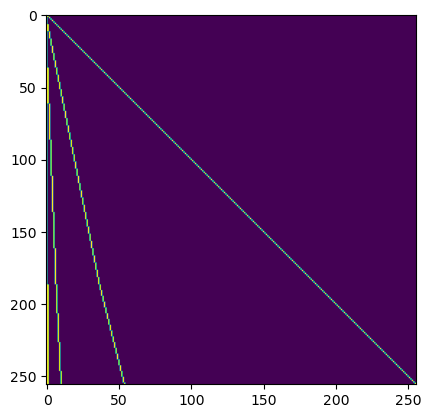

In [8]:
medusa_buffers = generate_medusa_buffers(medusa_choices, device='cpu')
for item in medusa_buffers:
    print(item)
medusa_attn_mask = medusa_buffers['medusa_attn_mask']
print('Medusa attention mask shape: ', medusa_attn_mask.shape)
plt.imshow(medusa_attn_mask[0,0].cpu().numpy())

Run inference

In [9]:
accept_lengths_tree = []
print(f"Medusa choices:{medusa_choices}\n")
print(medusa_buffers["tree_indices"])
# print(f"tree_indices={medusa_buffers["tree_indices"]}\n")
with torch.inference_mode():
    new_token = 0
    input_ids = tokenizer([prompt]).input_ids
    input_len = len(input_ids[0])
    input_ids = torch.as_tensor(input_ids).cuda()
    model.current_length_data.zero_() # this is for rerun
    reset_medusa_mode(model)
    medusa_buffers = generate_medusa_buffers(
                medusa_choices, device=model.base_model.device
            )
    medusa_logits, logits = initialize_medusa(
            input_ids, model, medusa_buffers["medusa_attn_mask"], past_key_values
        )
    cur_length = input_len + 1
    accept_lengths_tree.append(1)
    
    for i in range(1024):
        candidates, tree_candidates = generate_candidates(
                medusa_logits,
                logits,
                medusa_buffers["tree_indices"],
                medusa_buffers["retrieve_indices"],
            )
        if i==0:
            print(f"candidates={candidates}\n")
            print(f"tree_candidates={tree_candidates}\n")
        medusa_logits, logits, outputs = tree_decoding(
                model,
                tree_candidates,
                past_key_values,
                medusa_buffers["medusa_position_ids"],
                input_ids,
                medusa_buffers["retrieve_indices"],
            )
        best_candidate, accept_length = evaluate_posterior(
                logits, candidates, temperature = 0, posterior_threshold = 0, posterior_alpha = 0
            )
        input_ids, logits, medusa_logits, new_token = update_inference_inputs(
                input_ids,
                candidates,
                best_candidate,
                accept_length,
                medusa_buffers["retrieve_indices"],
                outputs,
                logits,
                medusa_logits,
                new_token,
                past_key_values_data,
                current_length_data,
            )
        
        accept_length_tree = input_ids.shape[1] - cur_length
        cur_length = accept_length_tree + cur_length
        accept_lengths_tree.append(accept_length_tree)
        # if model.tokenizer.eos_token_id in input_ids[0, input_len:]:
        #     break
# print('Decode:', tokenizer.batch_decode(input_ids[:,input_len:]))

Medusa choices:[[0], [1], [2], [3], [4], [5], [0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [1, 0], [1, 1], [1, 2], [1, 3], [1, 4], [2, 0], [2, 1], [2, 2], [2, 3], [2, 4], [3, 0], [3, 1], [3, 2], [3, 3], [3, 4], [4, 0], [4, 1], [4, 2], [4, 3], [4, 4], [5, 0], [5, 1], [5, 2], [5, 3], [5, 4], [0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 1, 0], [0, 1, 1], [0, 1, 2], [0, 1, 3], [0, 1, 4], [0, 2, 0], [0, 2, 1], [0, 2, 2], [0, 2, 3], [0, 2, 4], [0, 3, 0], [0, 3, 1], [0, 3, 2], [0, 3, 3], [0, 3, 4], [0, 4, 0], [0, 4, 1], [0, 4, 2], [0, 4, 3], [0, 4, 4], [1, 0, 0], [1, 0, 1], [1, 0, 2], [1, 0, 3], [1, 0, 4], [1, 1, 0], [1, 1, 1], [1, 1, 2], [1, 1, 3], [1, 1, 4], [1, 2, 0], [1, 2, 1], [1, 2, 2], [1, 2, 3], [1, 2, 4], [1, 3, 0], [1, 3, 1], [1, 3, 2], [1, 3, 3], [1, 3, 4], [1, 4, 0], [1, 4, 1], [1, 4, 2], [1, 4, 3], [1, 4, 4], [2, 0, 0], [2, 0, 1], [2, 0, 2], [2, 0, 3], [2, 0, 4], [2, 1, 0], [2, 1, 1], [2, 1, 2], [2, 1, 3], [2, 1, 4], [2, 2, 0], [2, 2, 1], [2, 2, 2], [2, 2, 3], [2, 2, 4],

Calculate avg length

Avg. accept tree length: 3.3092682926829267


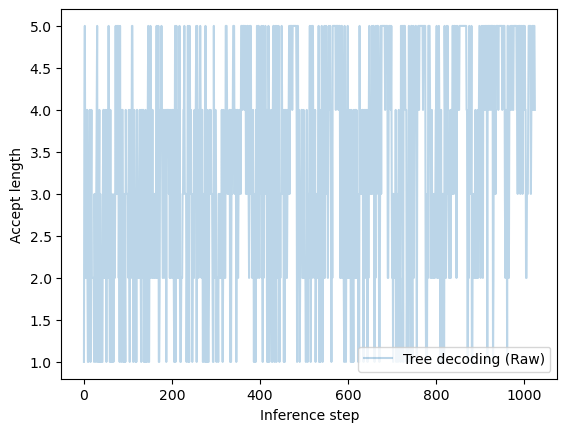

In [10]:
def moving_average(data, window_size=5):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Unsmoothed plots with transparency
plt.plot(accept_lengths_tree, label='Tree decoding (Raw)', alpha=0.3)
# plt.plot(accept_lengths, label='List decoding (Raw)', alpha=0.3)

# # Smoothed plots
# window_size = 5  # You can adjust this as needed
# plt.plot(moving_average(accept_lengths_tree, window_size), label='Tree decoding (Smoothed)', color='tab:blue')
# plt.plot(moving_average(accept_lengths, window_size), label='List decoding (Smoothed)', color='tab:orange')

plt.xlabel('Inference step')
plt.ylabel('Accept length')
plt.legend()

print('Avg. accept tree length:', np.mean(accept_lengths_tree))
# print('Avg. accept list length:', np.mean(accept_lengths))

plt.show()

# for dataset record by Jinwei Yao
# dataset: shareGPT-- https://huggingface.co/datasets/Aeala/ShareGPT_Vicuna_unfiltered

# structure: Tree ID, Meta: Tree Structure, Token Tree size; 1. prompt; 2. Accept_length; 3. Avg_accept_length

In [12]:
# Load dataset and Select first 200 traces
from datasets import load_dataset


In [24]:
# for each tree size, profile Medusa
dataset = load_dataset('HuggingFaceH4/mt_bench_prompts')

Generating train split:   0%|          | 0/80 [00:00<?, ? examples/s]

In [25]:
# example

first__trace = dataset['train']['prompt'][0]
print(len(dataset['train']))
# 打印1条 traces
for trace in first__trace:
    print(trace)

80
Compose an engaging travel blog post about a recent trip to Hawaii, highlighting cultural experiences and must-see attractions.
Rewrite your previous response. Start every sentence with the letter A.


In [58]:
medusa_choices = mc_sim_7b_63
# medusa_choices = vicuna_7b_stage1_ablation
medusa_choices = TreeD_256
print(f"Medusa choices:{medusa_choices}\n")
print(medusa_buffers["tree_indices"])
trace_num= len(dataset['train']['prompt'])
print(f"Dataset has {trace_num} in total!\n")

import json
from tqdm import tqdm
# example
# tree_data = [
#     {
#         "Tree ID": 1,
#         "Tree Structure": [0, 0, 1],
#         "Token Tree size": 10,
#         "Records": [
#             {
#                 "prompt": "This is prompt 1",
#                 "Accept_length": 5,
#                 "Avg_accept_length": 4.5
#             },
#             {
#                 "prompt": "This is prompt 2",
#                 "Accept_length": 7,
#                 "Avg_accept_length": 6.2
#             }
#         ]
#     },
#     # 添加更多的数据项...
# ] 
tree_setting=[TreeA_32, mc_sim_7b_63, TreeC_96, TreeB_128,  TreeD_256]
tree_data=[]

for index, select_tree in enumerate(tree_setting):
    
    tree_data.append({
            "Tree_ID":  index,
            "Tree_Structure": select_tree,
            "Token_Tree_size": len(select_tree)+1,
            "Records": []
        })
    
        # print(f"tree_indices={medusa_buffers["tree_indices"]}\n")
    with torch.inference_mode():
        for trace in tqdm(range(trace_num), desc="Processing traces"):
            past_key_values, past_key_values_data, current_length_data = initialize_past_key_values(model.base_model)
            model.past_key_values = past_key_values
            model.past_key_values_data = past_key_values_data
            model.current_length_data = current_length_data
            
            model.current_length_data.zero_() # this is for rerun
            prompt = dataset['train']['prompt'][trace ]
            # print(prompt)
            input_ids = tokenizer([prompt]).input_ids
            input_len = len(input_ids[0])
            # print('Input token length:', len(input_ids[0]))
            # print('Init KV cache shape for attention modules:', model.past_key_values[0][0].shape, model.past_key_values[0][1].shape)
            accept_lengths_tree = []
            
            new_token = 0
            
            input_ids = torch.as_tensor(input_ids).cuda()
            model.current_length_data.zero_() # this is for rerun
            reset_medusa_mode(model)
            medusa_buffers = generate_medusa_buffers(
                        medusa_choices, device=model.base_model.device
                    )
            medusa_logits, logits = initialize_medusa(
                    input_ids, model, medusa_buffers["medusa_attn_mask"], past_key_values
                )
            cur_length = input_len + 1
            accept_lengths_tree.append(1)
            
            for i in range(699):
                candidates, tree_candidates = generate_candidates(
                        medusa_logits,
                        logits,
                        medusa_buffers["tree_indices"],
                        medusa_buffers["retrieve_indices"],
                    )
                # if i==0:
                #     print(f"candidates={candidates}\n")
                #     print(f"tree_candidates={tree_candidates}\n")
                medusa_logits, logits, outputs = tree_decoding(
                        model,
                        tree_candidates,
                        past_key_values,
                        medusa_buffers["medusa_position_ids"],
                        input_ids,
                        medusa_buffers["retrieve_indices"],
                    )
                best_candidate, accept_length = evaluate_posterior(
                        logits, candidates, temperature = 0, posterior_threshold = 0, posterior_alpha = 0
                    )
                input_ids, logits, medusa_logits, new_token = update_inference_inputs(
                        input_ids,
                        candidates,
                        best_candidate,
                        accept_length,
                        medusa_buffers["retrieve_indices"],
                        outputs,
                        logits,
                        medusa_logits,
                        new_token,
                        past_key_values_data,
                        current_length_data,
                    )
                
                accept_length_tree = input_ids.shape[1] - cur_length
                cur_length = accept_length_tree + cur_length
                accept_lengths_tree.append(accept_length_tree)
                # if model.tokenizer.eos_token_id in input_ids[0, input_len:]:
                #     break
            
        # print('Decode:', tokenizer.batch_decode(input_ids[:,input_len:]))
            avg_len = np.mean(accept_lengths_tree)
            # print(f"Avg. accept tree length for trace {trace} = {avg_len} " )
            for tree in tree_data:
                if tree["Tree_ID"] == index:
                    tree["Records"].append({
                    "prompt": prompt,
                    "Accept_length": accept_lengths_tree,
                    "Avg_accept_length": avg_len
                    })
    output_file = "tree_size"+str(len(select_tree)+1)+".json"
    with open(output_file, "w") as f:
        for tree in tree_data:
            # 写入 Tree ID, Tree Structure, Token Tree size
            if tree["Tree_ID"] == index:
                json.dump({
                    "Tree_ID": tree["Tree_ID"],
                    "Tree_Structure": tree["Tree_Structure"],
                    "Token_Tree_size": tree["Token_Tree_size"],
                    "Records":tree["Records"]
                    
                }, f)
                f.write("\n")  # 换行
    
        # f.write("\n") 
    print("Data has been written to", output_file)
# print(tree_data)


Medusa choices:[[0], [1], [2], [3], [4], [5], [0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [1, 0], [1, 1], [1, 2], [1, 3], [1, 4], [2, 0], [2, 1], [2, 2], [2, 3], [2, 4], [3, 0], [3, 1], [3, 2], [3, 3], [3, 4], [4, 0], [4, 1], [4, 2], [4, 3], [4, 4], [5, 0], [5, 1], [5, 2], [5, 3], [5, 4], [0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 1, 0], [0, 1, 1], [0, 1, 2], [0, 1, 3], [0, 1, 4], [0, 2, 0], [0, 2, 1], [0, 2, 2], [0, 2, 3], [0, 2, 4], [0, 3, 0], [0, 3, 1], [0, 3, 2], [0, 3, 3], [0, 3, 4], [0, 4, 0], [0, 4, 1], [0, 4, 2], [0, 4, 3], [0, 4, 4], [1, 0, 0], [1, 0, 1], [1, 0, 2], [1, 0, 3], [1, 0, 4], [1, 1, 0], [1, 1, 1], [1, 1, 2], [1, 1, 3], [1, 1, 4], [1, 2, 0], [1, 2, 1], [1, 2, 2], [1, 2, 3], [1, 2, 4], [1, 3, 0], [1, 3, 1], [1, 3, 2], [1, 3, 3], [1, 3, 4], [1, 4, 0], [1, 4, 1], [1, 4, 2], [1, 4, 3], [1, 4, 4], [2, 0, 0], [2, 0, 1], [2, 0, 2], [2, 0, 3], [2, 0, 4], [2, 1, 0], [2, 1, 1], [2, 1, 2], [2, 1, 3], [2, 1, 4], [2, 2, 0], [2, 2, 1], [2, 2, 2], [2, 2, 3], [2, 2, 4],

Processing traces: 100%|██████████| 80/80 [43:46<00:00, 32.83s/it]


Data has been written to tree_size32.json


Processing traces: 100%|██████████| 80/80 [43:43<00:00, 32.80s/it]


Data has been written to tree_size64.json


Processing traces: 100%|██████████| 80/80 [44:19<00:00, 33.24s/it]


Data has been written to tree_size96.json


Processing traces: 100%|██████████| 80/80 [45:40<00:00, 34.26s/it]


Data has been written to tree_size128.json


Processing traces: 100%|██████████| 80/80 [43:45<00:00, 32.82s/it]

Data has been written to tree_size256.json


In [51]:
output_file = "result.json"
with open(output_file, "w") as f:
    for tree in tree_data:
        # 写入 Tree ID, Tree Structure, Token Tree size
        json.dump({
            "Tree_ID": tree["Tree_ID"],
            "Tree_Structure": tree["Tree_Structure"],
            "Token_Tree_size": tree["Token_Tree_size"],
            "Records":tree["Records"]
            
        }, f)
        f.write("\n")  # 换行

    # f.write("\n") 
print("Data has been written to", output_file)

Data has been written to result.json


Avg. accept tree length: 4.103218645948946


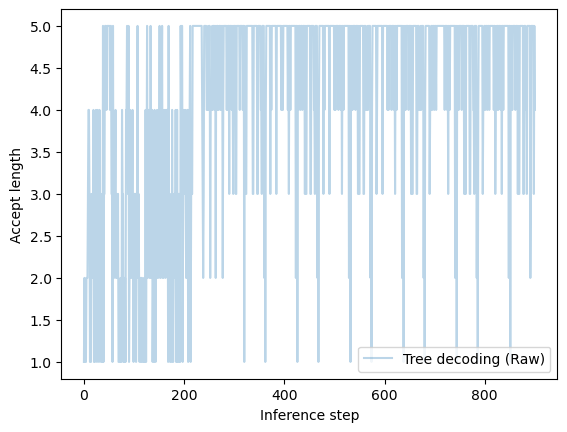

In [32]:


# Unsmoothed plots with transparency
plt.plot(accept_lengths_tree, label='Tree decoding (Raw)', alpha=0.3)
# plt.plot(accept_lengths, label='List decoding (Raw)', alpha=0.3)

# # Smoothed plots
# window_size = 5  # You can adjust this as needed
# plt.plot(moving_average(accept_lengths_tree, window_size), label='Tree decoding (Smoothed)', color='tab:blue')
# plt.plot(moving_average(accept_lengths, window_size), label='List decoding (Smoothed)', color='tab:orange')

plt.xlabel('Inference step')
plt.ylabel('Accept length')
plt.legend()

print('Avg. accept tree length:', np.mean(accept_lengths_tree))
# print('Avg. accept list length:', np.mean(accept_lengths))

plt.show()